In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
from datetime import datetime
import statsmodels.formula.api as smf

from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from pylab import mpl
import platform

# 根据操作系统设置中文字体
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
elif system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS使用Arial Unicode MS
    plt.rcParams['axes.unicode_minus'] = False
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # Linux使用文泉驿微米黑
    plt.rcParams['axes.unicode_minus'] = False
# 输出矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 设置pandas显示选项
pd.set_option('display.max_columns', None)

print(f"当前操作系统: {system}")
print(f"字体设置: {plt.rcParams['font.sans-serif']}")

当前操作系统: Windows
字体设置: ['SimHei']


In [4]:
cross = pd.read_csv(r'C:\Users\冤种千斤\Desktop\代码\第十二次作业\TRD_Mnth202509.csv')
from pandas.tseries.offsets import MonthEnd
# 处理月份格式
cross['month'] = pd.to_datetime(cross['Trdmnt'], format='%Y-%m') + MonthEnd(1)
# 补齐股票代码 如果不满6位 在前面补上0
cross['Stkcd'] = cross['Stkcd'].apply(lambda x: '{:0>6}'.format(x)) # 6位股票代码
# 重命名列以匹配后续代码
cross.rename(columns={'Mretwd': 'Return', 'Msmvosd': 'floatingvalue', 'Msmvttl': 'totalvalue'}, inplace=True)

# 导入无风险利率数据
rf_data = pd.read_csv('Marketret_mon_stock2024.csv')
# 处理月份格式
rf_data['month'] = pd.to_datetime(rf_data['month'], format='%b %Y') + MonthEnd(1)
# 只保留需要的列
rf_data = rf_data[['month', 'rfmonth']]

# 合并无风险利率到cross
cross = pd.merge(cross, rf_data, on='month', how='left')

# 添加一个序列 用来统计公司上市的第几个月
cross = cross.sort_values(by=['Stkcd', 'month'])
cross['list_month'] = cross.groupby('Stkcd').cumcount() + 1

# 计算超额收益率
cross['ret'] = cross['Return'] - cross['rfmonth']
cross['floatingvalue'] = cross['floatingvalue'] * 1000
cross['totalvalue'] = cross['totalvalue'] * 1000

cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret
0,000001,1991-04,3,49.00,30,43.68,13400,6.150000e+05,1.157520e+09,2.118487e+09,20,NaN,NaN,4,1991-04-03,NaN,NaN,1991-04-30,0.006651,1,NaN
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,2,-0.128345
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,3,-0.119551
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,4,-0.137013
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,5,-0.417680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886908,920992,2025-05,6,20.00,30,20.46,92609592,1.922463e+09,5.707967e+08,1.979115e+09,19,0.051312,0.051715,64,2023-04-25,0.0,0.0,2025-05-31,NaN,32,NaN
886909,920992,2025-06,3,20.40,30,21.26,73152031,1.580767e+09,5.931152e+08,2.056500e+09,20,0.039101,0.039101,64,2023-04-25,0.0,0.0,2025-06-30,NaN,33,NaN
886910,920992,2025-07,1,21.13,31,22.44,96064221,2.126994e+09,6.260351e+08,2.170642e+09,23,0.055503,0.055503,64,2023-04-25,0.0,0.0,2025-07-31,NaN,34,NaN
886911,920992,2025-08,1,22.12,29,21.65,63953451,1.432608e+09,6.039955e+08,2.094225e+09,21,-0.035205,-0.035205,64,2023-04-25,0.0,0.0,2025-08-31,NaN,35,NaN


In [ ]:
# 方法1：补全所有个股的日期序列，再使用shift
# 创建所有日期和股票代码的完整组合
all_months = pd.DataFrame(cross['month'].unique(), columns=['month'])
all_stocks = pd.DataFrame(cross['Stkcd'].unique(), columns=['Stkcd'])

# 创建笛卡尔积 - 所有股票和所有月份的组合
full_index = all_stocks.merge(all_months, how='cross')

# 将原始数据合并到完整索引中
cross_full = full_index.merge(cross, on=['Stkcd', 'month'], how='left')

# 按股票代码和月份排序
cross_full = cross_full.sort_values(['Stkcd', 'month'])

# 使用shift生成下月收益率
cross_full['next_ret'] = cross_full.groupby('Stkcd')['ret'].shift(-1)

# 合并回原始数据，保留原始数据存在的行
cross = cross.merge(cross_full[['Stkcd', 'month', 'next_ret']], 
                    on=['Stkcd', 'month'], how='left')

# 添加一个变量，用来统计过去一年的交易日数量之和
cross['Cumsum_tradingday'] = cross.groupby('Stkcd')['Ndaytrd'].transform(
    lambda x: x.rolling(window=12, min_periods=1).sum()
)

print("方法1完成：补全日期序列后使用shift")

# 筛选时间范围
# 假设是筛选1995年1月31日之后的数据
cross = cross[(cross['month'] >= '1995-01-31') & (cross['month'] <= '2024-12-31')]

cross

方法1完成：补全日期序列后使用shift


,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret_x,next_ret_y,next_ret,Cumsum_tradingday
45,000001,1995-01,3,10.50,27,10.54,17488100,1.867690e+08,3.134297e+09,4.543463e+09,19,0.005725,0.005725,4,1994-09-02,NaN,NaN,1995-01-31,0.008719,46,-0.002994,-0.000180,-0.000180,-0.000180,247.0
46,000001,1995-02,13,10.60,28,10.63,8544200,9.192790e+07,3.161060e+09,4.582260e+09,12,0.008539,0.008539,4,1994-09-02,NaN,NaN,1995-02-28,0.008719,47,-0.000180,0.003511,0.003511,0.003511,244.0
47,000001,1995-03,1,10.63,31,10.76,18810600,2.059094e+08,3.199719e+09,4.638299e+09,23,0.012230,0.012230,4,1994-09-02,NaN,NaN,1995-03-31,0.008719,48,0.003511,-0.108161,-0.108161,-0.108161,244.0
48,000001,1995-04,3,10.78,28,9.69,13235500,1.380604e+08,2.881531e+09,4.177055e+09,20,-0.099442,-0.099442,4,1994-09-02,NaN,NaN,1995-04-30,0.008719,49,-0.108161,0.002633,0.002633,0.002633,243.0
49,000001,1995-05,2,9.69,31,9.80,53197900,6.049730e+08,2.914242e+09,4.224473e+09,22,0.011352,0.011352,4,1994-09-02,NaN,NaN,1995-05-31,0.008719,50,0.002633,-0.073005,-0.073005,-0.073005,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886899,920992,2024-08,1,8.50,30,8.19,14436632,1.185912e+08,2.284861e+08,7.922264e+08,22,-0.037603,-0.037603,64,2023-04-25,0.0,0.0,2024-08-31,0.001118,23,-0.038721,0.276049,0.276049,0.276049,242.0
886900,920992,2024-09,2,8.15,30,10.46,18109819,1.566140e+08,2.918149e+08,1.011806e+09,19,0.277167,0.277167,64,2023-04-25,0.0,0.0,2024-09-30,0.001118,24,0.276049,0.389895,0.389895,0.389895,241.0
886901,920992,2024-10,8,13.02,31,14.55,86774237,1.145494e+09,4.059185e+08,1.407435e+09,18,0.391013,0.391013,64,2023-04-25,0.0,0.0,2024-10-31,0.001118,25,0.389895,0.241494,0.241494,0.241494,242.0
886902,920992,2024-11,1,14.69,29,18.08,130783392,2.346534e+09,5.043990e+08,1.748895e+09,21,0.242612,0.242612,64,2023-04-25,0.0,0.0,2024-11-30,0.001118,26,0.241494,-0.243928,-0.243928,-0.243928,241.0


In [ ]:
from pandas.tseries.offsets import MonthEnd  # 导入MonthEnd，用于日期偏移操作
# 读取市场收益率数据
Market_ret = pd.read_csv(r'C:\Users\冤种千斤\Desktop\代码\第十二次作业\Marketret_mon_stock2024.csv')
# 转换月份字符串为日期格式：使用MonthEnd将日期调整到当月最后一天
# MonthEnd(0) 表示将日期调整到当月最后一天
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
# 将'month'列设置为索引，便于时间序列操作
Market_ret.set_index('month', inplace=True)
# 按时间索引排序，确保时间顺序正确
Market_ret.sort_index(inplace=True)
# 删除可能存在的无用列（通常是CSV文件中的索引列）
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
# 重命名收益率列，将'ret'改为更明确的'MKT'（市场收益率）
Market_ret.rename(columns={'ret': 'MKT'}, inplace=True)
# 显示处理后的市场收益率数据
Market_ret

,MarketR,MarketR_e,rfmonth,MKT,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [10]:
#引出cross将所选内容编到表格中
cross = pd.merge(cross,Market_ret[['MKT']],left_on='month',right_on='month',how='left')
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret_x,next_ret_y,next_ret,Cumsum_tradingday,MKT
0,000001,1995-01,3,10.50,27,10.54,17488100,1.867690e+08,3.134297e+09,4.543463e+09,19,0.005725,0.005725,4,1994-09-02,NaN,NaN,1995-01-31,0.008719,46,-0.002994,-0.000180,-0.000180,-0.000180,247.0,-0.125017
1,000001,1995-02,13,10.60,28,10.63,8544200,9.192790e+07,3.161060e+09,4.582260e+09,12,0.008539,0.008539,4,1994-09-02,NaN,NaN,1995-02-28,0.008719,47,-0.000180,0.003511,0.003511,0.003511,244.0,-0.022778
2,000001,1995-03,1,10.63,31,10.76,18810600,2.059094e+08,3.199719e+09,4.638299e+09,23,0.012230,0.012230,4,1994-09-02,NaN,NaN,1995-03-31,0.008719,48,0.003511,-0.108161,-0.108161,-0.108161,244.0,0.122163
3,000001,1995-04,3,10.78,28,9.69,13235500,1.380604e+08,2.881531e+09,4.177055e+09,20,-0.099442,-0.099442,4,1994-09-02,NaN,NaN,1995-04-30,0.008719,49,-0.108161,0.002633,0.002633,0.002633,243.0,-0.113023
4,000001,1995-05,2,9.69,31,9.80,53197900,6.049730e+08,2.914242e+09,4.224473e+09,22,0.011352,0.011352,4,1994-09-02,NaN,NaN,1995-05-31,0.008719,50,0.002633,-0.073005,-0.073005,-0.073005,244.0,0.166736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831456,920992,2024-08,1,8.50,30,8.19,14436632,1.185912e+08,2.284861e+08,7.922264e+08,22,-0.037603,-0.037603,64,2023-04-25,0.0,0.0,2024-08-31,0.001118,23,-0.038721,0.276049,0.276049,0.276049,242.0,-0.032586
831457,920992,2024-09,2,8.15,30,10.46,18109819,1.566140e+08,2.918149e+08,1.011806e+09,19,0.277167,0.277167,64,2023-04-25,0.0,0.0,2024-09-30,0.001118,24,0.276049,0.389895,0.389895,0.389895,241.0,0.194874
831458,920992,2024-10,8,13.02,31,14.55,86774237,1.145494e+09,4.059185e+08,1.407435e+09,18,0.391013,0.391013,64,2023-04-25,0.0,0.0,2024-10-31,0.001118,25,0.389895,0.241494,0.241494,0.241494,242.0,-0.004527
831459,920992,2024-11,1,14.69,29,18.08,130783392,2.346534e+09,5.043990e+08,1.748895e+09,21,0.242612,0.242612,64,2023-04-25,0.0,0.0,2024-11-30,0.001118,26,0.241494,-0.243928,-0.243928,-0.243928,241.0,0.008606


In [ ]:
cross = cross[cross['Ndaytrd'] >= 7]
cross = cross[cross['Clsdt'] >= 5]
cross = cross[cross['list_month'] > 6]
cross = cross[cross['Cumsum_tradingday'] >= 100]
cross = cross[(cross['Markettype'] == 1) | (cross['Markettype'] == 4) | (cross['Markettype'] == 16)]
cross#筛选了

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret_x,next_ret_y,next_ret,Cumsum_tradingday,MKT
0,000001,1995-01,3,10.50,27,10.54,17488100,1.867690e+08,3.134297e+09,4.543463e+09,19,0.005725,0.005725,4,1994-09-02,NaN,NaN,1995-01-31,0.008719,46,-0.002994,-0.000180,-0.000180,-0.000180,247.0,-0.125017
1,000001,1995-02,13,10.60,28,10.63,8544200,9.192790e+07,3.161060e+09,4.582260e+09,12,0.008539,0.008539,4,1994-09-02,NaN,NaN,1995-02-28,0.008719,47,-0.000180,0.003511,0.003511,0.003511,244.0,-0.022778
2,000001,1995-03,1,10.63,31,10.76,18810600,2.059094e+08,3.199719e+09,4.638299e+09,23,0.012230,0.012230,4,1994-09-02,NaN,NaN,1995-03-31,0.008719,48,0.003511,-0.108161,-0.108161,-0.108161,244.0,0.122163
3,000001,1995-04,3,10.78,28,9.69,13235500,1.380604e+08,2.881531e+09,4.177055e+09,20,-0.099442,-0.099442,4,1994-09-02,NaN,NaN,1995-04-30,0.008719,49,-0.108161,0.002633,0.002633,0.002633,243.0,-0.113023
4,000001,1995-05,2,9.69,31,9.80,53197900,6.049730e+08,2.914242e+09,4.224473e+09,22,0.011352,0.011352,4,1994-09-02,NaN,NaN,1995-05-31,0.008719,50,0.002633,-0.073005,-0.073005,-0.073005,244.0,0.166736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781621,605599,2024-08,1,11.51,30,10.74,60492042,6.675452e+08,6.300920e+09,8.353334e+09,22,-0.065274,-0.065274,1,2022-09-09,0.0,0.0,2024-08-31,0.001118,36,-0.066392,0.105958,0.105958,0.105958,242.0,-0.032586
781622,605599,2024-09,2,10.56,30,11.89,68255221,7.093424e+08,9.247778e+09,9.247778e+09,19,0.107076,0.107076,1,2024-09-09,0.0,0.0,2024-09-30,0.001118,37,0.105958,-0.105407,-0.105407,-0.105407,241.0,0.194874
781623,605599,2024-10,8,12.91,31,10.65,100720810,1.106652e+09,8.283334e+09,8.283334e+09,18,-0.104289,-0.104289,1,2024-09-09,0.0,0.0,2024-10-31,0.001118,38,-0.105407,0.078694,0.078694,0.078694,242.0,-0.004527
781624,605599,2024-11,1,10.63,29,11.50,108258572,1.199394e+09,8.944445e+09,8.944445e+09,21,0.079812,0.079812,1,2024-09-09,0.0,0.0,2024-11-30,0.001118,39,0.078694,-0.014161,-0.014161,-0.014161,241.0,0.008606


In [12]:
EP = pd.read_csv('EP_individual_mon2024.csv')
EP['Stkcd'] = EP['Stkcd'].apply(lambda x: '{:0>6}'.format(x))
EP#引进新数据

,Stkcd,month,matchearnings,recent_earnings,floatingvalue,totalvalue,ratio,Clsprc,ep,ep_recent
0,000001,1991.250000,NaN,NaN,1.157520e+09,2.118487e+09,0.54639,43.68,NaN,NaN
1,000001,1991.333333,NaN,NaN,1.016010e+09,1.859497e+09,0.54639,38.34,NaN,NaN
2,000001,1991.416667,NaN,NaN,9.007350e+08,1.648521e+09,0.54639,33.99,NaN,NaN
3,000001,1991.500000,NaN,NaN,7.828100e+08,1.432695e+09,0.54639,29.54,NaN,NaN
4,000001,1991.583333,NaN,NaN,6.748338e+08,1.346275e+09,0.50126,15.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
809599,605599,2024.583333,6.614476e+08,3.884148e+08,6.300920e+09,8.353334e+09,0.75430,10.74,0.079184,0.046498
809600,605599,2024.666667,6.614476e+08,3.884148e+08,9.247778e+09,9.247778e+09,1.00000,11.89,0.071525,0.042001
809601,605599,2024.750000,6.455339e+08,5.286127e+08,8.283334e+09,8.283334e+09,1.00000,10.65,0.077932,0.063816
809602,605599,2024.833333,6.455339e+08,5.286127e+08,8.944445e+09,8.944445e+09,1.00000,11.50,0.072171,0.059100


In [ ]:
# 重新读取EP数据并转换month列
EP = pd.read_csv('EP_individual_mon2024.csv')
# 将股票代码转换为6位字符串格式，确保格式统一
EP['Stkcd'] = EP['Stkcd'].apply(lambda x: f'{x:0>6}')
# 转换month列为日期格式
# 根据数据规律：1991.250000 -> 1991年3月，1991.333333 -> 1991年4月
# 小数部分 = (month - 1) / 12, 所以 month_num = round(小数部分 * 12) + 1
EP['year'] = EP['month'].astype(int)
EP['month_decimal'] = EP['month'] - EP['year']
EP['month_num'] = (EP['month_decimal'] * 12).round().astype(int) + 1
# 如果month_num > 12，说明是下一年的1月
EP.loc[EP['month_num'] > 12, 'year'] += 1
EP.loc[EP['month_num'] > 12, 'month_num'] -= 12
EP['month'] = pd.to_datetime(EP['year'].astype(str) + '-' + EP['month_num'].astype(str) + '-01')
# 删除辅助列
EP = EP.drop(['year', 'month_decimal', 'month_num'], axis=1)
# 将日期调整为月末
EP['month'] = EP['month'] + MonthEnd(0)
# 只保留需要的列并重新排序
EP = EP[['Stkcd', 'month', 'ep', 'ep_recent']]
EP

,Stkcd,month,ep,ep_recent
0,000001,1991-04-30,NaN,NaN
1,000001,1991-05-31,NaN,NaN
2,000001,1991-06-30,NaN,NaN
3,000001,1991-07-31,NaN,NaN
4,000001,1991-08-31,NaN,NaN
...,...,...,...,...
809599,605599,2024-08-31,0.079184,0.046498
809600,605599,2024-09-30,0.071525,0.042001
809601,605599,2024-10-31,0.077932,0.063816
809602,605599,2024-11-30,0.072171,0.059100


In [14]:
cross = pd.merge(cross,EP[['Stkcd','month','ep','ep_recent']],on=['Stkcd','month'],how='left')
cross#同上述将所选内容引进cross表格

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret_x,next_ret_y,next_ret,Cumsum_tradingday,MKT,ep,ep_recent
0,000001,1995-01,3,10.50,27,10.54,17488100,1.867690e+08,3.134297e+09,4.543463e+09,19,0.005725,0.005725,4,1994-09-02,NaN,NaN,1995-01-31,0.008719,46,-0.002994,-0.000180,-0.000180,-0.000180,247.0,-0.125017,0.078427,0.078427
1,000001,1995-02,13,10.60,28,10.63,8544200,9.192790e+07,3.161060e+09,4.582260e+09,12,0.008539,0.008539,4,1994-09-02,NaN,NaN,1995-02-28,0.008719,47,-0.000180,0.003511,0.003511,0.003511,244.0,-0.022778,0.077763,0.077763
2,000001,1995-03,1,10.63,31,10.76,18810600,2.059094e+08,3.199719e+09,4.638299e+09,23,0.012230,0.012230,4,1994-09-02,NaN,NaN,1995-03-31,0.008719,48,0.003511,-0.108161,-0.108161,-0.108161,244.0,0.122163,0.076823,0.076823
3,000001,1995-04,3,10.78,28,9.69,13235500,1.380604e+08,2.881531e+09,4.177055e+09,20,-0.099442,-0.099442,4,1994-09-02,NaN,NaN,1995-04-30,0.008719,49,-0.108161,0.002633,0.002633,0.002633,243.0,-0.113023,0.085306,0.085306
4,000001,1995-05,2,9.69,31,9.80,53197900,6.049730e+08,2.914242e+09,4.224473e+09,22,0.011352,0.011352,4,1994-09-02,NaN,NaN,1995-05-31,0.008719,50,0.002633,-0.073005,-0.073005,-0.073005,244.0,0.166736,0.084349,0.084349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732137,605599,2024-08,1,11.51,30,10.74,60492042,6.675452e+08,6.300920e+09,8.353334e+09,22,-0.065274,-0.065274,1,2022-09-09,0.0,0.0,2024-08-31,0.001118,36,-0.066392,0.105958,0.105958,0.105958,242.0,-0.032586,0.079184,0.046498
732138,605599,2024-09,2,10.56,30,11.89,68255221,7.093424e+08,9.247778e+09,9.247778e+09,19,0.107076,0.107076,1,2024-09-09,0.0,0.0,2024-09-30,0.001118,37,0.105958,-0.105407,-0.105407,-0.105407,241.0,0.194874,0.071525,0.042001
732139,605599,2024-10,8,12.91,31,10.65,100720810,1.106652e+09,8.283334e+09,8.283334e+09,18,-0.104289,-0.104289,1,2024-09-09,0.0,0.0,2024-10-31,0.001118,38,-0.105407,0.078694,0.078694,0.078694,242.0,-0.004527,0.077932,0.063816
732140,605599,2024-11,1,10.63,29,11.50,108258572,1.199394e+09,8.944445e+09,8.944445e+09,21,0.079812,0.079812,1,2024-09-09,0.0,0.0,2024-11-30,0.001118,39,0.078694,-0.014161,-0.014161,-0.014161,241.0,0.008606,0.072171,0.059100


In [ ]:
# 计算每个月 'ep' 列的10个分位数（10%~90%，间隔10%）
# 按月份分组，对每个月的ep值计算分位数
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['ep'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
   
   
)

# 将多级索引重置为普通列，便于后续处理
fenweishu = fenweishu.reset_index()
# 现在列包括：month（月份）, level_1（分位点）, ep（分位数值）
# 使用数据透视表将分位数结果转换为宽格式
# index='month': 行索引为月份
# columns='level_1': 列索引为分位点（0.1, 0.2, ...）
# values='ep': 填充的值是对应的ep分位数
fenweishu = fenweishu.pivot_table(index='month', columns='level_1', values='ep')
# 将分位数数值列名改为更直观的英文名称
fenweishu.columns = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1995-01-31,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585
1995-02-28,0.017802,0.027244,0.035524,0.039235,0.046534,0.057727,0.068244,0.085852,0.107936
1995-03-31,0.019806,0.025710,0.031130,0.036242,0.039984,0.047927,0.059745,0.079132,0.097067
1995-04-30,0.022996,0.030191,0.037497,0.048093,0.057527,0.068974,0.082006,0.094234,0.118343
1995-05-31,0.019335,0.023981,0.031124,0.039584,0.047728,0.057994,0.069575,0.084349,0.107694
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.065342,-0.015765,0.001985,0.013019,0.023183,0.033007,0.044546,0.058770,0.081748
2024-09-30,-0.051694,-0.012428,0.001630,0.010812,0.019079,0.027164,0.037395,0.048900,0.068312
2024-10-31,-0.047610,-0.013923,0.000275,0.008623,0.016624,0.025175,0.035106,0.047547,0.067220


In [16]:
portfolio = pd.merge(cross,fenweishu,on='month')
portfolio['sort'] = np.where(
    portfolio['ep'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['ep'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['ep'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['ep'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['ep'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['ep'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['ep'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['ep'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['ep'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio = portfolio.dropna(subset=['floatingvalue','next_ret','ep'])
portfolio

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret_x,next_ret_y,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,one,two,three,four,five,six,seven,eight,nine,sort
0,000001,1995-01,3,10.50,27,10.54,17488100,1.867690e+08,3.134297e+09,4.543463e+09,19,0.005725,0.005725,4,1994-09-02,NaN,NaN,1995-01-31,0.008719,46,-0.002994,-0.000180,-0.000180,-0.000180,247.0,-0.125017,0.078427,0.078427,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585,P8
1,000001,1995-02,13,10.60,28,10.63,8544200,9.192790e+07,3.161060e+09,4.582260e+09,12,0.008539,0.008539,4,1994-09-02,NaN,NaN,1995-02-28,0.008719,47,-0.000180,0.003511,0.003511,0.003511,244.0,-0.022778,0.077763,0.077763,0.017802,0.027244,0.035524,0.039235,0.046534,0.057727,0.068244,0.085852,0.107936,P8
2,000001,1995-03,1,10.63,31,10.76,18810600,2.059094e+08,3.199719e+09,4.638299e+09,23,0.012230,0.012230,4,1994-09-02,NaN,NaN,1995-03-31,0.008719,48,0.003511,-0.108161,-0.108161,-0.108161,244.0,0.122163,0.076823,0.076823,0.019806,0.025710,0.031130,0.036242,0.039984,0.047927,0.059745,0.079132,0.097067,P8
3,000001,1995-04,3,10.78,28,9.69,13235500,1.380604e+08,2.881531e+09,4.177055e+09,20,-0.099442,-0.099442,4,1994-09-02,NaN,NaN,1995-04-30,0.008719,49,-0.108161,0.002633,0.002633,0.002633,243.0,-0.113023,0.085306,0.085306,0.022996,0.030191,0.037497,0.048093,0.057527,0.068974,0.082006,0.094234,0.118343,P8
4,000001,1995-05,2,9.69,31,9.80,53197900,6.049730e+08,2.914242e+09,4.224473e+09,22,0.011352,0.011352,4,1994-09-02,NaN,NaN,1995-05-31,0.008719,50,0.002633,-0.073005,-0.073005,-0.073005,244.0,0.166736,0.084349,0.084349,0.019335,0.023981,0.031124,0.039584,0.047728,0.057994,0.069575,0.084349,0.107694,P8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732136,605599,2024-07,1,12.78,31,11.49,54949980,6.610917e+08,6.740928e+09,8.936667e+09,23,-0.097408,-0.097408,1,2022-09-09,0.0,0.0,2024-07-31,0.001184,35,-0.098592,-0.066392,-0.066392,-0.066392,243.0,-0.000624,0.078272,0.028314,-0.061968,-0.014115,0.003415,0.012878,0.022664,0.032734,0.043958,0.058448,0.081198,P9
732137,605599,2024-08,1,11.51,30,10.74,60492042,6.675452e+08,6.300920e+09,8.353334e+09,22,-0.065274,-0.065274,1,2022-09-09,0.0,0.0,2024-08-31,0.001118,36,-0.066392,0.105958,0.105958,0.105958,242.0,-0.032586,0.079184,0.046498,-0.065342,-0.015765,0.001985,0.013019,0.023183,0.033007,0.044546,0.058770,0.081748,P9
732138,605599,2024-09,2,10.56,30,11.89,68255221,7.093424e+08,9.247778e+09,9.247778e+09,19,0.107076,0.107076,1,2024-09-09,0.0,0.0,2024-09-30,0.001118,37,0.105958,-0.105407,-0.105407,-0.105407,241.0,0.194874,0.071525,0.042001,-0.051694,-0.012428,0.001630,0.010812,0.019079,0.027164,0.037395,0.048900,0.068312,Pmax
732139,605599,2024-10,8,12.91,31,10.65,100720810,1.106652e+09,8.283334e+09,8.283334e+09,18,-0.104289,-0.104289,1,2024-09-09,0.0,0.0,2024-10-31,0.001118,38,-0.105407,0.078694,0.078694,0.078694,242.0,-0.004527,0.077932,0.063816,-0.047610,-0.013923,0.000275,0.008623,0.016624,0.025175,0.035106,0.047547,0.067220,Pmax


In [ ]:
# 计算各投资组合的加权平均收益率
# 按月份和分组(sort)进行分组，对每个组内的股票计算加权平均收益率
portfolio_value = pd.DataFrame(
    portfolio.groupby(['month', 'sort']).apply(
        # 使用自定义函数计算加权平均值
        lambda x: np.average(x['next_ret'], weights=x['floatingvalue']),
        # include_groups=False: 不在apply函数的x中包含分组列，提高性能
        include_groups=False
    )
)
portfolio_value = portfolio_value.reset_index()
# 现在列包括：月份、分组、以及加权平均收益率（默认列名为0）

# 重命名列，使其含义更清晰
portfolio_value.columns = ['month', 'sort', 'p']
# 'month': 月份
# 'sort': 投资组合分组（可能按ep分位数分组）
# 'p': 投资组合的加权平均收益率

# 将日期调整为月末，确保日期格式统一
portfolio_value['month'] = portfolio_value['month'] + MonthEnd(1)
# 显示计算后的投资组合收益率数据
portfolio_value

,month,sort,p
0,1995-02-28,P1,-0.046564
1,1995-02-28,P2,-0.039864
2,1995-02-28,P3,0.004335
3,1995-02-28,P4,0.010141
4,1995-02-28,P5,-0.046855
...,...,...,...
3585,2024-12-31,P6,-0.020564
3586,2024-12-31,P7,-0.021901
3587,2024-12-31,P8,-0.000751
3588,2024-12-31,P9,0.001804


In [18]:
portfolio_value = portfolio_value.pivot_table(index='month',
                                                    columns='sort',
                                                    values='p')
portfolio_value['My_portfolio'] = portfolio_value['Pmax'] - portfolio_value['P1']
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-02-28,-0.046564,-0.039864,0.004335,0.010141,-0.046855,-0.014133,0.004822,0.004398,0.005364,-0.004510,0.042054
1995-03-31,0.166651,0.039614,0.186807,0.105647,0.145939,0.211369,0.125131,0.011332,0.115488,0.033143,-0.133508
1995-04-30,-0.120087,-0.098151,-0.098700,-0.116309,-0.102409,-0.120334,-0.137053,-0.103988,-0.097787,-0.116950,0.003137
1995-05-31,0.169245,0.211190,0.224196,0.246332,0.226090,0.166345,0.208711,0.125688,0.106342,0.059119,-0.110126
1995-06-30,-0.101912,-0.111554,-0.118523,-0.122750,-0.120498,-0.086887,-0.073876,-0.080503,-0.079607,-0.063207,0.038705
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.038232,-0.053478,-0.049764,-0.065088,-0.056185,-0.036431,-0.038029,-0.032099,-0.029894,-0.017219,0.021013
2024-09-30,0.291391,0.265119,0.228272,0.232738,0.215657,0.219249,0.195558,0.235590,0.203023,0.137434,-0.153957
2024-10-31,0.136777,0.144915,0.086483,0.065876,0.092307,0.023809,-0.023444,-0.057672,-0.037094,-0.045320,-0.182097


In [19]:
portfolio_value = portfolio_value['1995-01':'2024-12'].copy()
portfolio_value['month'] = pd.date_range(start='1995-01', periods=len(portfolio_value), freq='ME')
portfolio_value.set_index('month', inplace = True)
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-01-31,-0.046564,-0.039864,0.004335,0.010141,-0.046855,-0.014133,0.004822,0.004398,0.005364,-0.004510,0.042054
1995-02-28,0.166651,0.039614,0.186807,0.105647,0.145939,0.211369,0.125131,0.011332,0.115488,0.033143,-0.133508
1995-03-31,-0.120087,-0.098151,-0.098700,-0.116309,-0.102409,-0.120334,-0.137053,-0.103988,-0.097787,-0.116950,0.003137
1995-04-30,0.169245,0.211190,0.224196,0.246332,0.226090,0.166345,0.208711,0.125688,0.106342,0.059119,-0.110126
1995-05-31,-0.101912,-0.111554,-0.118523,-0.122750,-0.120498,-0.086887,-0.073876,-0.080503,-0.079607,-0.063207,0.038705
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,-0.038232,-0.053478,-0.049764,-0.065088,-0.056185,-0.036431,-0.038029,-0.032099,-0.029894,-0.017219,0.021013
2024-08-31,0.291391,0.265119,0.228272,0.232738,0.215657,0.219249,0.195558,0.235590,0.203023,0.137434,-0.153957
2024-09-30,0.136777,0.144915,0.086483,0.065876,0.092307,0.023809,-0.023444,-0.057672,-0.037094,-0.045320,-0.182097


In [20]:
model_port = smf.ols('My_portfolio ~ 1',
                 data=portfolio_value['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())#验证回归

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 04 Dec 2025   Prob (F-statistic):                nan
Time:                        16:04:49   Log-Likelihood:                 398.41
No. Observations:                 299   AIC:                            -794.8
Df Residuals:                     298   BIC:                            -791.1
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0048      0.003      1.596      0.1

In [21]:
# 计算每个月 'totalvalue' 列的第30百分位数（即30%分位点）
# 按月份分组，对每个月的totalvalue值计算30%分位数
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['totalvalue'].quantile(0.3)
    # quantile(0.3) 返回每个月的30%分位点值
    # 结果是一个以月份为索引、分位数值为值的Series
)

# 重命名列，使其含义更明确
fenweishu.columns = ['fenweishu_guimo']
# 'fenweishu_guimo' 表示规模的分位数，这里特指30%分位点

# 显示计算后的分位数数据
fenweishu

,fenweishu_guimo
month,
1995-01-31,4.713757e+08
1995-02-28,4.685400e+08
1995-03-31,5.569249e+08
1995-04-30,4.913312e+08
1995-05-31,5.796345e+08
...,...
2024-08-31,2.687391e+09
2024-09-30,3.322109e+09
2024-10-31,3.538658e+09


In [22]:
cross_new = pd.merge(cross,fenweishu,on='month',how='left')
cross_new = cross_new[cross_new['totalvalue'] > cross_new['fenweishu_guimo']]
cross_new#引进cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret_x,next_ret_y,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo
0,000001,1995-01,3,10.50,27,10.54,17488100,1.867690e+08,3.134297e+09,4.543463e+09,19,0.005725,0.005725,4,1994-09-02,NaN,NaN,1995-01-31,0.008719,46,-0.002994,-0.000180,-0.000180,-0.000180,247.0,-0.125017,0.078427,0.078427,4.713757e+08
1,000001,1995-02,13,10.60,28,10.63,8544200,9.192790e+07,3.161060e+09,4.582260e+09,12,0.008539,0.008539,4,1994-09-02,NaN,NaN,1995-02-28,0.008719,47,-0.000180,0.003511,0.003511,0.003511,244.0,-0.022778,0.077763,0.077763,4.685400e+08
2,000001,1995-03,1,10.63,31,10.76,18810600,2.059094e+08,3.199719e+09,4.638299e+09,23,0.012230,0.012230,4,1994-09-02,NaN,NaN,1995-03-31,0.008719,48,0.003511,-0.108161,-0.108161,-0.108161,244.0,0.122163,0.076823,0.076823,5.569249e+08
3,000001,1995-04,3,10.78,28,9.69,13235500,1.380604e+08,2.881531e+09,4.177055e+09,20,-0.099442,-0.099442,4,1994-09-02,NaN,NaN,1995-04-30,0.008719,49,-0.108161,0.002633,0.002633,0.002633,243.0,-0.113023,0.085306,0.085306,4.913312e+08
4,000001,1995-05,2,9.69,31,9.80,53197900,6.049730e+08,2.914242e+09,4.224473e+09,22,0.011352,0.011352,4,1994-09-02,NaN,NaN,1995-05-31,0.008719,50,0.002633,-0.073005,-0.073005,-0.073005,244.0,0.166736,0.084349,0.084349,5.796345e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732137,605599,2024-08,1,11.51,30,10.74,60492042,6.675452e+08,6.300920e+09,8.353334e+09,22,-0.065274,-0.065274,1,2022-09-09,0.0,0.0,2024-08-31,0.001118,36,-0.066392,0.105958,0.105958,0.105958,242.0,-0.032586,0.079184,0.046498,2.687391e+09
732138,605599,2024-09,2,10.56,30,11.89,68255221,7.093424e+08,9.247778e+09,9.247778e+09,19,0.107076,0.107076,1,2024-09-09,0.0,0.0,2024-09-30,0.001118,37,0.105958,-0.105407,-0.105407,-0.105407,241.0,0.194874,0.071525,0.042001,3.322109e+09
732139,605599,2024-10,8,12.91,31,10.65,100720810,1.106652e+09,8.283334e+09,8.283334e+09,18,-0.104289,-0.104289,1,2024-09-09,0.0,0.0,2024-10-31,0.001118,38,-0.105407,0.078694,0.078694,0.078694,242.0,-0.004527,0.077932,0.063816,3.538658e+09
732140,605599,2024-11,1,10.63,29,11.50,108258572,1.199394e+09,8.944445e+09,8.944445e+09,21,0.079812,0.079812,1,2024-09-09,0.0,0.0,2024-11-30,0.001118,39,0.078694,-0.014161,-0.014161,-0.014161,241.0,0.008606,0.072171,0.059100,3.721918e+09


In [ ]:
# 计算每个月 'ep' 列的10个分位数（10%~90%，间隔10%）
# 按月份分组，对每个月的ep值计算分位数
fenweishu = pd.DataFrame(
    cross_new.groupby(['month'])['ep'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
   
    
)

# 将多级索引重置为普通列，便于后续处理
fenweishu = fenweishu.reset_index()
# 现在列包括：month（月份）, level_1（分位点）, ep（分位数值）
# index='month': 行索引为月份
# columns='level_1': 列索引为分位点（0.1, 0.2, ...）
# values='ep': 填充的值是对应的ep分位数
fenweishu = fenweishu.pivot_table(index='month', columns='level_1', values='ep')
fenweishu.columns = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# 对应关系：one→10%, two→20%, ..., nine→90%
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1995-01-31,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.112330
1995-02-28,0.020711,0.027461,0.034961,0.042902,0.047414,0.057495,0.078630,0.097774,0.110024
1995-03-31,0.019606,0.024940,0.027630,0.033458,0.039421,0.047050,0.061474,0.081681,0.104285
1995-04-30,0.023986,0.029562,0.037292,0.047827,0.057979,0.072796,0.088687,0.101487,0.129023
1995-05-31,0.019987,0.023862,0.030861,0.038425,0.047612,0.058119,0.075383,0.096088,0.117188
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.039747,-0.002716,0.009528,0.019653,0.029525,0.040558,0.052464,0.067280,0.091531
2024-09-30,-0.035716,-0.003492,0.006545,0.014759,0.023376,0.032459,0.043275,0.056039,0.077364
2024-10-31,-0.036275,-0.006633,0.004194,0.012034,0.020970,0.030453,0.041643,0.054546,0.077341


In [24]:
portfolio = pd.merge(cross_new,fenweishu,on='month')
portfolio['sort'] = np.where(
    portfolio['ep'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['ep'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['ep'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['ep'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['ep'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['ep'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['ep'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['ep'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['ep'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio = portfolio.dropna(subset=['floatingvalue','next_ret','ep'])
portfolio

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret_x,next_ret_y,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo,one,two,three,four,five,six,seven,eight,nine,sort
0,000001,1995-01,3,10.50,27,10.54,17488100,1.867690e+08,3.134297e+09,4.543463e+09,19,0.005725,0.005725,4,1994-09-02,NaN,NaN,1995-01-31,0.008719,46,-0.002994,-0.000180,-0.000180,-0.000180,247.0,-0.125017,0.078427,0.078427,4.713757e+08,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.112330,P7
1,000001,1995-02,13,10.60,28,10.63,8544200,9.192790e+07,3.161060e+09,4.582260e+09,12,0.008539,0.008539,4,1994-09-02,NaN,NaN,1995-02-28,0.008719,47,-0.000180,0.003511,0.003511,0.003511,244.0,-0.022778,0.077763,0.077763,4.685400e+08,0.020711,0.027461,0.034961,0.042902,0.047414,0.057495,0.078630,0.097774,0.110024,P7
2,000001,1995-03,1,10.63,31,10.76,18810600,2.059094e+08,3.199719e+09,4.638299e+09,23,0.012230,0.012230,4,1994-09-02,NaN,NaN,1995-03-31,0.008719,48,0.003511,-0.108161,-0.108161,-0.108161,244.0,0.122163,0.076823,0.076823,5.569249e+08,0.019606,0.024940,0.027630,0.033458,0.039421,0.047050,0.061474,0.081681,0.104285,P8
3,000001,1995-04,3,10.78,28,9.69,13235500,1.380604e+08,2.881531e+09,4.177055e+09,20,-0.099442,-0.099442,4,1994-09-02,NaN,NaN,1995-04-30,0.008719,49,-0.108161,0.002633,0.002633,0.002633,243.0,-0.113023,0.085306,0.085306,4.913312e+08,0.023986,0.029562,0.037292,0.047827,0.057979,0.072796,0.088687,0.101487,0.129023,P7
4,000001,1995-05,2,9.69,31,9.80,53197900,6.049730e+08,2.914242e+09,4.224473e+09,22,0.011352,0.011352,4,1994-09-02,NaN,NaN,1995-05-31,0.008719,50,0.002633,-0.073005,-0.073005,-0.073005,244.0,0.166736,0.084349,0.084349,5.796345e+08,0.019987,0.023862,0.030861,0.038425,0.047612,0.058119,0.075383,0.096088,0.117188,P8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512404,605599,2024-07,1,12.78,31,11.49,54949980,6.610917e+08,6.740928e+09,8.936667e+09,23,-0.097408,-0.097408,1,2022-09-09,0.0,0.0,2024-07-31,0.001184,35,-0.098592,-0.066392,-0.066392,-0.066392,243.0,-0.000624,0.078272,0.028314,2.762999e+09,-0.037500,-0.000649,0.010341,0.019670,0.029240,0.039655,0.051984,0.066966,0.089746,P9
512405,605599,2024-08,1,11.51,30,10.74,60492042,6.675452e+08,6.300920e+09,8.353334e+09,22,-0.065274,-0.065274,1,2022-09-09,0.0,0.0,2024-08-31,0.001118,36,-0.066392,0.105958,0.105958,0.105958,242.0,-0.032586,0.079184,0.046498,2.687391e+09,-0.039747,-0.002716,0.009528,0.019653,0.029525,0.040558,0.052464,0.067280,0.091531,P9
512406,605599,2024-09,2,10.56,30,11.89,68255221,7.093424e+08,9.247778e+09,9.247778e+09,19,0.107076,0.107076,1,2024-09-09,0.0,0.0,2024-09-30,0.001118,37,0.105958,-0.105407,-0.105407,-0.105407,241.0,0.194874,0.071525,0.042001,3.322109e+09,-0.035716,-0.003492,0.006545,0.014759,0.023376,0.032459,0.043275,0.056039,0.077364,P9
512407,605599,2024-10,8,12.91,31,10.65,100720810,1.106652e+09,8.283334e+09,8.283334e+09,18,-0.104289,-0.104289,1,2024-09-09,0.0,0.0,2024-10-31,0.001118,38,-0.105407,0.078694,0.078694,0.078694,242.0,-0.004527,0.077932,0.063816,3.538658e+09,-0.036275,-0.006633,0.004194,0.012034,0.020970,0.030453,0.041643,0.054546,0.077341,Pmax


In [25]:
portfolio_value =  pd.DataFrame(
    portfolio.groupby(['month','sort']).apply(lambda x: np.average(x['next_ret'],weights = x['floatingvalue']),include_groups=False))
portfolio_value = portfolio_value.reset_index()
portfolio_value.columns = ['month', 'sort', 'p']
portfolio_value['month'] = portfolio_value['month'] + MonthEnd(1)
portfolio_value

,month,sort,p
0,1995-02-28,P1,-0.046777
1,1995-02-28,P2,0.014555
2,1995-02-28,P3,0.008496
3,1995-02-28,P4,-0.051571
4,1995-02-28,P5,-0.031356
...,...,...,...
3585,2024-12-31,P6,-0.026344
3586,2024-12-31,P7,-0.015496
3587,2024-12-31,P8,0.007514
3588,2024-12-31,P9,-0.003017


In [26]:
# 将投资组合收益率数据从长格式转换为宽格式
# 使用数据透视表进行转换
portfolio_value = portfolio_value.pivot_table(
    index='month',      # 行索引：月份
    columns='sort',     # 列索引：投资组合分组
    values='p'          # 填充的值：投资组合收益率(p)
)
# 转换后，每行是一个月份，每列是一个投资组合分组的收益率

# 创建一个新的投资组合：Pmax和P1的收益率差值（做多Pmax，做空P1）
portfolio_value['My_portfolio'] = portfolio_value['Pmax'] - portfolio_value['P1']
# 'My_portfolio' 表示一个对冲组合：
# 显示转换后的投资组合收益率数据
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-02-28,-0.046777,0.014555,0.008496,-0.051571,-0.031356,0.013759,0.000756,0.007651,0.025464,-0.010515,0.036262
1995-03-31,0.165296,0.035090,0.209913,0.111720,0.207424,0.192222,0.013933,0.075066,0.096007,0.026763,-0.138532
1995-04-30,-0.131195,-0.098671,-0.108246,-0.082227,-0.115333,-0.116426,-0.136463,-0.109025,-0.090291,-0.120392,0.010802
1995-05-31,0.179534,0.208098,0.220244,0.250802,0.203709,0.145200,0.122211,0.139460,0.067827,0.061691,-0.117843
1995-06-30,-0.115782,-0.113925,-0.120305,-0.137234,-0.131440,-0.102541,-0.082283,-0.093331,-0.063897,-0.069104,0.046678
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.050075,-0.051880,-0.069000,-0.054196,-0.044302,-0.045110,-0.028238,-0.035817,-0.019721,-0.018440,0.031635
2024-09-30,0.276281,0.241689,0.238392,0.224931,0.206499,0.233799,0.213797,0.214329,0.189604,0.134840,-0.141441
2024-10-31,0.123495,0.138160,0.067615,0.099600,0.030935,0.010993,-0.059571,-0.040672,-0.040566,-0.044238,-0.167733


In [27]:
portfolio_value = portfolio_value['2000-02':'2024-12'].copy()
portfolio_value['month'] = pd.date_range(start='2000-02', periods=len(portfolio_value), freq='ME')
portfolio_value.set_index('month', inplace = True)
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
2000-02-29,0.166357,0.165800,0.138800,0.107954,0.151389,0.094652,0.070353,0.091512,0.061355,0.089514,-0.076843
2000-03-31,0.079685,-0.001584,0.007175,0.019191,0.038322,0.037642,0.055191,0.052076,0.065257,0.043202,-0.036483
2000-04-30,0.034669,-0.029604,-0.007395,-0.011148,0.028850,0.022619,0.041919,0.038311,0.000506,0.032381,-0.002288
2000-05-31,0.012548,0.006910,0.006493,0.043984,0.024917,-0.004197,0.028055,0.005743,0.028147,0.044220,0.031672
2000-06-30,-0.001656,-0.000891,-0.025373,0.002718,0.000285,0.014655,0.042497,0.047704,0.060273,0.069934,0.071590
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.050075,-0.051880,-0.069000,-0.054196,-0.044302,-0.045110,-0.028238,-0.035817,-0.019721,-0.018440,0.031635
2024-09-30,0.276281,0.241689,0.238392,0.224931,0.206499,0.233799,0.213797,0.214329,0.189604,0.134840,-0.141441
2024-10-31,0.123495,0.138160,0.067615,0.099600,0.030935,0.010993,-0.059571,-0.040672,-0.040566,-0.044238,-0.167733


In [ ]:
model_port = smf.ols(
    'My_portfolio ~ 1',  # 回归公式：只包含常数项（截距），不包含其他解释变量
    data=portfolio_value['1996-01':'2024-12']  # 数据范围：1996年1月到2024年12月
).fit(
    cov_type="HAC",  # 使用异方差自相关一致标准误（Heteroskedasticity-Autocorrelation Consistent）
    cov_kwds={'maxlags': 6}  # HAC参数：最大滞后阶数为6，用于调整标准误
)

# 打印回归结果摘要
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 04 Dec 2025   Prob (F-statistic):                nan
Time:                        16:13:48   Log-Likelihood:                 410.14
No. Observations:                 299   AIC:                            -818.3
Df Residuals:                     298   BIC:                            -814.6
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0078      0.003      2.757      0.0

In [29]:
MYPOR = portfolio_value[['P1','Pmax','My_portfolio']]
MYPOR = MYPOR.dropna()
MYPOR = MYPOR['2000-02':'2024-12']
MYPOR = pd.merge(MYPOR,Market_ret[['MKT']],on='month',how='left')
MYPOR['month'] = pd.date_range(start='2000-02', periods=len(MYPOR), freq='ME')
MYPOR.set_index('month',inplace=True)
MYPOR

,P1,Pmax,My_portfolio,MKT
month,,,,
2000-02-29,0.166357,0.089514,-0.076843,0.120168
2000-03-31,0.079685,0.043202,-0.036483,0.054070
2000-04-30,0.034669,0.032381,-0.002288,0.011158
2000-05-31,0.012548,0.044220,0.031672,0.025835
2000-06-30,-0.001656,0.069934,0.071590,0.021865
...,...,...,...,...
2024-08-31,-0.050075,-0.018440,0.031635,-0.032586
2024-09-30,0.276281,0.134840,-0.141441,0.194874
2024-10-31,0.123495,-0.044238,-0.167733,-0.004527


In [31]:
# 对投资组合收益率进行CAPM模型回归分析
model_port = smf.ols(
    'My_portfolio ~ MKT',  # 回归公式：投资组合收益率对市场收益率回归
    data=MYPOR['2000-01':'2024-12']  # 数据范围：2000年1月到2024年12月
).fit(
    cov_type='HAC',  # 使用异方差自相关一致标准误
    cov_kwds={'maxlags': 6}  # HAC参数：最大滞后阶数为6
)

# 打印回归结果摘要
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     12.91
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           0.000383
Time:                        16:15:10   Log-Likelihood:                 423.90
No. Observations:                 299   AIC:                            -843.8
Df Residuals:                     297   BIC:                            -836.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0093      0.003      3.297      0.0

In [32]:
from linearmodels import FamaMacBeth
# subset the cross data from 2000-01 to 2024-12
cross_reg = cross_new[cross_new['month'] >= '2000-01']
cross_reg = cross_reg.set_index(['Stkcd', 'month']) # 设置multi-index
cross_reg['log_totalvalue'] = np.log(cross_reg['totalvalue'])

model = FamaMacBeth.from_formula('next_ret ~ 1 + log_totalvalue + ep', data=cross_reg.dropna(subset=['next_ret','log_totalvalue','ep']))
# 一般fm回归结果展示的是Newey-West调整后的t值，.fit()中做如下设置
# 其中`bandwidth`是Newey-West滞后阶数，选取方式为lag = 4(T/100) ^ (2/9)
# 若不需要Newey-West调整则去掉括号内所有设置。
# choose bandwidth auto
res = model.fit(cov_type= 'kernel',debiased = False,bandwidth=6)
print(res.summary)

                            FamaMacBeth Estimation Summary                           
Dep. Variable:                    next_ret   R-squared:                     4.721e-05
Estimator:                     FamaMacBeth   R-squared (Between):             -0.0864
No. Observations:                   459097   R-squared (Within):               0.0009
Date:                     Thu, Dec 04 2025   R-squared (Overall):           4.721e-05
Time:                             16:15:23   Log-likelihood                 2.643e+05
Cov. Estimator:    Fama-MacBeth Kernel Cov                                           
                                             F-statistic:                      10.837
Entities:                             4341   P-value                           0.0000
Avg Obs:                            105.76   Distribution:                F(2,459094)
Min Obs:                            1.0000                                           
Max Obs:                            299.00   F-statist

In [ ]:
# 计算各投资策略的价格序列（累计净值）
MYPOR['price_portfolio'] = (1 + MYPOR['My_portfolio']).cumprod()
MYPOR['price_p1'] = (1 + MYPOR['P1']).cumprod()
MYPOR['price_pmax'] = (1 + MYPOR['Pmax']).cumprod()
MYPOR['price_market'] = (1 + MYPOR['MKT']).cumprod()
MYPOR

,P1,Pmax,My_portfolio,MKT,price_portfolio,price_p1,price_pmax,price_market
month,,,,,,,,
2000-02-29,0.166357,0.089514,-0.076843,0.120168,0.923157,1.166357,1.089514,1.120168
2000-03-31,0.079685,0.043202,-0.036483,0.054070,0.889477,1.259299,1.136583,1.180735
2000-04-30,0.034669,0.032381,-0.002288,0.011158,0.887442,1.302958,1.173387,1.193910
2000-05-31,0.012548,0.044220,0.031672,0.025835,0.915549,1.319308,1.225275,1.224755
2000-06-30,-0.001656,0.069934,0.071590,0.021865,0.981093,1.317123,1.310963,1.251534
...,...,...,...,...,...,...,...,...
2024-08-31,-0.050075,-0.018440,0.031635,-0.032586,7.307666,0.306645,5.636594,2.253865
2024-09-30,0.276281,0.134840,-0.141441,0.194874,6.274063,0.391365,6.396632,2.693085
2024-10-31,0.123495,-0.044238,-0.167733,-0.004527,5.221696,0.439697,6.113656,2.680893


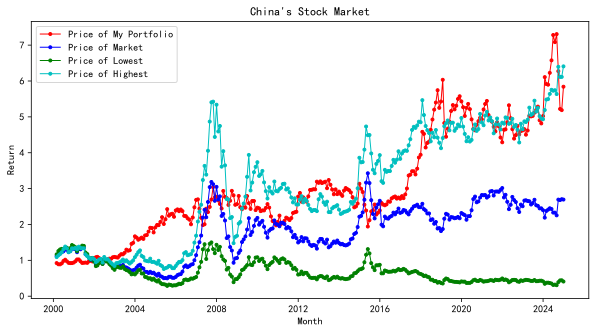

In [34]:
fig = plt.figure(figsize=(10, 5))
plt.plot(
    'price_portfolio',  
    '.-r', 
    label='Price of My Portfolio',  
    linewidth=1, 
    data=MYPOR)  
plt.title("China's Stock Market") 
plt.xlabel('Month') 
plt.ylabel('Return') 

plt.plot(
    'price_market', 
    '.-b', 
    label='Price of Market', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_p1', 
    '.-g', 
    label='Price of Lowest', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_pmax', 
    '.-c', 
    label='Price of Highest', 
    linewidth=1, 
    data=MYPOR) 
plt.legend() # 显示图例
fig = plt.gcf()
plt.show();

In [ ]:
# 获取最新一期数据进行分析
latest_month = portfolio['month'].max()
# 检查最新月份是否有效
if pd.isna(latest_month):
    raise ValueError("无法定位最新月份，请检查 portfolio 数据是否为空。")
# 提取最新月份的数据
latest_month_value = portfolio.loc[portfolio['month'] == latest_month].copy()
print(f"最新一期数据: {latest_month.strftime('%Y-%m')}, 样本数量: {len(latest_month_value)}")
# 筛选成长股组合（P1 - 低EP组，通常代表低市盈率的价值股，但这里可能是高市盈率的成长股）
growth_stocks = latest_month_value.loc[latest_month_value['sort'] == 'P1'].copy()
# 按ep排序（升序：ep值小的在前，如果是EP指标，小值可能代表高市盈率）
growth_stocks = growth_stocks.sort_values('ep', ascending=True)

print("=== 成长股组合(P1 - 低EP)分析 ===")
print(f"公司数量: {len(growth_stocks)}")
print(f"平均EP: {growth_stocks['ep'].mean():.4f}")
print(f"EP范围: {growth_stocks['ep'].min():.4f} 到 {growth_stocks['ep'].max():.4f}")
print(f"平均市值: {growth_stocks['totalvalue'].mean():.2f} 万元\n")
print("前28家成长股(EP最低/市盈率可能最高):")
print(growth_stocks[['Stkcd', 'totalvalue', 'ep', 'ret']].head(28))

最新一期数据: 2024-11, 样本数量: 3093
=== 成长股组合(P1 - 低EP)分析 ===
公司数量: 310
平均EP: -0.1146
EP范围: -1.1417 到 -0.0347
平均市值: 11406903645.26 万元

前28家成长股(EP最低/市盈率可能最高):
         Stkcd    totalvalue        ep       ret
343291  600376  7.558126e+09 -1.141660 -0.001118
338291  600340  1.127151e+10 -1.027659  0.262040
441433  600881  5.880534e+09 -0.810666 -0.182113
370707  600569  5.342704e+09 -0.563060 -0.093801
378446  600606  3.260579e+10 -0.438367  0.108930
372672  600581  5.062295e+09 -0.379649 -0.097272
454128  601011  5.153138e+09 -0.377203  0.158365
432035  600841  5.528030e+09 -0.370723 -0.014153
398809  600691  5.654837e+09 -0.365228 -0.005302
382310  600622  5.788786e+09 -0.361750 -0.221320
148454  002305  4.144776e+09 -0.346784  0.120948
3209    000016  8.030867e+09 -0.314147 -0.286629
13708   000069  2.451516e+10 -0.305915  0.029287
19036   000402  1.195572e+10 -0.295636  0.119330
410168  600743  4.340287e+09 -0.291724  0.015365
245038  300423  4.169145e+09 -0.287230  0.234870
67161   000761  1

In [36]:
# 查看价值股组合(Pmax - 高EP值)的样本
value_stocks = latest_month_value[latest_month_value['sort'] == 'Pmax'].copy()
value_stocks = value_stocks.sort_values('ep', ascending=False)

print(f"=== 价值股组合(Pmax - 高EP)分析 ===")
print(f"公司数量: {len(value_stocks)}")
print(f"平均EP值: {value_stocks['ep'].mean():.4f}")
print(f"EP范围: {value_stocks['ep'].min():.4f} 到 {value_stocks['ep'].max():.4f}")
print(f"平均市值: {value_stocks['totalvalue'].mean():.2f} 万元\n")

# 显示EP最高的20家价值股
print("EP最高的20家价值股(市盈率最低):")
print(value_stocks[['Stkcd', 'totalvalue', 'ep', 'ret']].head(20))

=== 价值股组合(Pmax - 高EP)分析 ===
公司数量: 310
平均EP值: 0.1149
EP范围: 0.0751 到 0.2787
平均市值: 69544096809.90 万元

EP最高的20家价值股(市盈率最低):
         Stkcd    totalvalue        ep       ret
24476   000498  9.912333e+09  0.278727 -0.016622
402743  600710  1.164314e+10  0.270822 -0.013313
470025  601668  2.488297e+11  0.253724 -0.007762
321324  600248  1.706715e+10  0.245478 -0.003321
479927  601997  2.208344e+10  0.238759  0.007229
466987  601577  3.438428e+10  0.234661  0.002403
275641  600015  1.204760e+11  0.227398  0.069603
460293  601186  1.064050e+11  0.218434  0.034716
459848  601169  1.209379e+11  0.213837  0.011271
356     000001  2.208393e+11  0.211063 -0.001118
477130  601919  1.734226e+11  0.210491 -0.069019
473872  601838  6.071833e+10  0.203985  0.032648
459452  601166  3.749761e+11  0.199498 -0.013700
476740  601916  6.247886e+10  0.197068  0.020008
473632  601818  1.670645e+11  0.196119  0.042360
465388  601390  1.316822e+11  0.195535 -0.001118
491038  603323  9.652298e+09  0.195198  0.040466

In [38]:
# 获取这20家价值股的详细信息
value_stock_codes = ['000498', '600710', '601668', '600248', '601997', '601577', '600015', '601186', 
                     '601169', '000001', '601919', '601838', '601166', '601916', '601818', '601390', 
                     '603323', '600919', '601229', '600502']

# 创建价值股公司信息字典
value_company_info = {
    '000498': ('山东路桥', '公路桥梁建设', '山东济南'),
    '600710': ('苏美达', '机电设备进出口', '江苏南京'),
    '601668': ('中国建筑', '建筑工程施工', '北京市'),
    '600248': ('陕西建工', '建筑工程施工', '陕西西安'),
    '601997': ('贵阳银行', '商业银行', '贵州贵阳'),
    '601577': ('长沙银行', '商业银行', '湖南长沙'),
    '600015': ('华夏银行', '股份制商业银行', '北京市'),
    '601186': ('中国铁建', '铁路工程建设', '北京市'),
    '601169': ('北京银行', '城市商业银行', '北京市'),
    '000001': ('平安银行', '股份制商业银行', '广东深圳'),
    '601919': ('中远海控', '集装箱航运', '上海市'),
    '601838': ('成都银行', '城市商业银行', '四川成都'),
    '601166': ('兴业银行', '股份制商业银行', '福建福州'),
    '601916': ('浙商银行', '股份制商业银行', '浙江杭州'),
    '601818': ('光大银行', '股份制商业银行', '北京市'),
    '601390': ('中国中铁', '铁路工程建设', '北京市'),
    '603323': ('苏农银行', '农村商业银行', '江苏苏州'),
    '600919': ('江苏银行', '城市商业银行', '江苏南京'),
    '601229': ('上海银行', '城市商业银行', '上海市'),
    '600502': ('安徽建工', '建筑工程施工', '安徽合肥')
}

# 创建详细信息DataFrame
value_info = []
for idx, row in value_stocks[['Stkcd', 'totalvalue', 'ep', 'ret']].head(20).iterrows():
    stkcd = row['Stkcd']
    if stkcd in value_company_info:
        name, industry, location = value_company_info[stkcd]
        value_info.append({
            '股票代码': stkcd,
            '公司名称': name,
            '主营业务': industry,
            '注册地': location,
            '总市值(亿元)': f"{row['totalvalue']/1e8:.2f}",
            'EP值': f"{row['ep']:.4f}",
            '市盈率(PE)': f"{1/row['ep']:.2f}",
            '当期收益率': f"{row['ret']:.4%}"
        })

value_info_df = pd.DataFrame(value_info)
print("\n=== EP最高的20家价值股详细信息 ===")
print(value_info_df.to_string(index=False))


=== EP最高的20家价值股详细信息 ===
  股票代码 公司名称    主营业务  注册地 总市值(亿元)    EP值 市盈率(PE)    当期收益率
000498 山东路桥  公路桥梁建设 山东济南   99.12 0.2787    3.59 -1.6622%
600710  苏美达 机电设备进出口 江苏南京  116.43 0.2708    3.69 -1.3313%
601668 中国建筑  建筑工程施工  北京市 2488.30 0.2537    3.94 -0.7762%
600248 陕西建工  建筑工程施工 陕西西安  170.67 0.2455    4.07 -0.3321%
601997 贵阳银行    商业银行 贵州贵阳  220.83 0.2388    4.19  0.7229%
601577 长沙银行    商业银行 湖南长沙  343.84 0.2347    4.26  0.2403%
600015 华夏银行 股份制商业银行  北京市 1204.76 0.2274    4.40  6.9603%
601186 中国铁建  铁路工程建设  北京市 1064.05 0.2184    4.58  3.4716%
601169 北京银行  城市商业银行  北京市 1209.38 0.2138    4.68  1.1271%
000001 平安银行 股份制商业银行 广东深圳 2208.39 0.2111    4.74 -0.1118%
601919 中远海控   集装箱航运  上海市 1734.23 0.2105    4.75 -6.9019%
601838 成都银行  城市商业银行 四川成都  607.18 0.2040    4.90  3.2648%
601166 兴业银行 股份制商业银行 福建福州 3749.76 0.1995    5.01 -1.3700%
601916 浙商银行 股份制商业银行 浙江杭州  624.79 0.1971    5.07  2.0008%
601818 光大银行 股份制商业银行  北京市 1670.65 0.1961    5.10  4.2360%
601390 中国中铁  铁路工程建设  北京市 1316.82 0.1955    5.11 -0.1118%
603323

In [ ]:
# 计算投资组合的夏普比率（Sharpe Ratio）
# 夏普比率 = (投资组合平均收益率 - 无风险收益率) / 投资组合收益率标准差
sharpe_ratio = MYPOR['My_portfolio'].mean() / MYPOR['My_portfolio'].std() * np.sqrt(12)

print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 0.4385769983275541


In [40]:
# 计算累积收益率
MYPOR['cumulative_return'] = (1 + MYPOR['My_portfolio']).cumprod()

# 计算滚动最大值
MYPOR['rolling_max'] = MYPOR['cumulative_return'].cummax()

# 计算回撤
MYPOR['drawdown'] = MYPOR['cumulative_return'] / MYPOR['rolling_max'] - 1

# 计算最大回撤
max_drawdown = MYPOR['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -0.40056539952336245


In [41]:
# 找出最大回撤的时间
max_drawdown_end = MYPOR['drawdown'].idxmin() # 返回 Series 中最小值的索引
max_drawdown_start = MYPOR.loc[:max_drawdown_end, 'cumulative_return'].idxmax() # 这部分代码选择了从数据开始到 max_drawdown_end 时间点之间的所有累积收益率

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Maximum Drawdown Start Date: {max_drawdown_start}")
print(f"Maximum Drawdown End Date: {max_drawdown_end}")

Maximum Drawdown: -0.40056539952336245
Maximum Drawdown Start Date: 2013-06-30 00:00:00
Maximum Drawdown End Date: 2015-05-31 00:00:00


In [ ]:
portfolio_value#出表格

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
2000-02-29,0.166357,0.165800,0.138800,0.107954,0.151389,0.094652,0.070353,0.091512,0.061355,0.089514,-0.076843
2000-03-31,0.079685,-0.001584,0.007175,0.019191,0.038322,0.037642,0.055191,0.052076,0.065257,0.043202,-0.036483
2000-04-30,0.034669,-0.029604,-0.007395,-0.011148,0.028850,0.022619,0.041919,0.038311,0.000506,0.032381,-0.002288
2000-05-31,0.012548,0.006910,0.006493,0.043984,0.024917,-0.004197,0.028055,0.005743,0.028147,0.044220,0.031672
2000-06-30,-0.001656,-0.000891,-0.025373,0.002718,0.000285,0.014655,0.042497,0.047704,0.060273,0.069934,0.071590
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.050075,-0.051880,-0.069000,-0.054196,-0.044302,-0.045110,-0.028238,-0.035817,-0.019721,-0.018440,0.031635
2024-09-30,0.276281,0.241689,0.238392,0.224931,0.206499,0.233799,0.213797,0.214329,0.189604,0.134840,-0.141441
2024-10-31,0.123495,0.138160,0.067615,0.099600,0.030935,0.010993,-0.059571,-0.040672,-0.040566,-0.044238,-0.167733


In [43]:
# 定义不同的时间段
time_periods = [
    ('2000-02-29', '2007-12-31', '2000-2007'),
    ('2008-01-31', '2015-12-31', '2008-2015'),
    ('2016-01-31', '2024-12-31', '2016-2024')
]

# 计算每个时间段的价值溢价
period_results = []

for start_date, end_date, period_name in time_periods:
    # 筛选该时间段的数据
    period_data = portfolio_value[
        (portfolio_value.index >= start_date) & 
        (portfolio_value.index <= end_date)
    ].copy()
    
    if len(period_data) == 0:
        continue
    
    # 计算价值溢价 (Pmax - P1)
    value_premium_series = period_data['My_portfolio']
    # 计算统计量
    mean_premium = value_premium_series.mean()
    std_premium = value_premium_series.std()
    t_stat, p_value = stats.ttest_1samp(value_premium_series.dropna(), 0)
    
    # 年化收益率和夏普比率
    annual_ret = mean_premium * 12
    annual_std = std_premium * np.sqrt(12)
    sharpe = annual_ret / annual_std if annual_std > 0 else 0
    
    # 胜率
    win_rate = (value_premium_series > 0).sum() / len(value_premium_series.dropna())
    
    # 累积收益
    cumulative_ret = (1 + value_premium_series).prod() - 1
    
    period_results.append({
        '时期': period_name,
        '样本数': len(value_premium_series.dropna()),
        '月均溢价(%)': f'{mean_premium*100:.3f}',
        '年化溢价(%)': f'{annual_ret*100:.2f}',
        '年化波动(%)': f'{annual_std*100:.2f}',
        '夏普比率': f'{sharpe:.3f}',
        't统计量': f'{t_stat:.3f}',
        'p值': f'{p_value:.4f}',
        '胜率(%)': f'{win_rate*100:.2f}',
        '累积收益(%)': f'{cumulative_ret*100:.2f}'
    })

results_df = pd.DataFrame(period_results)
print("\n不同时期的价值效应:")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)
print("\n*** p<0.01, ** p<0.05, * p<0.1")
    


不同时期的价值效应:
       时期  样本数 月均溢价(%) 年化溢价(%) 年化波动(%)  夏普比率  t统计量     p值 胜率(%) 累积收益(%)
2000-2007   95   1.235   14.82   19.70 0.752 2.117 0.0369 57.89  177.37
2008-2015   96   0.066    0.79   23.31 0.034 0.096 0.9236 48.96  -13.81
2016-2024  108   1.010   12.12   20.78 0.583 1.749 0.0831 59.26  144.34

*** p<0.01, ** p<0.05, * p<0.1


In [47]:
import pandas as pd
from scipy import stats

# 使用市场收益率界定牛熊市
# 牛市: 市场收益率 > 中位数; 熊市: 市场收益率 < 中位数

# 首先检查 portfolio_value 的结构
print("portfolio_value 的列名:", portfolio_value.columns.tolist())
print("\nportfolio_value 的前几行:")
print(portfolio_value.head())

# 确保索引是 datetime 类型
if not isinstance(portfolio_value.index, pd.DatetimeIndex):
    portfolio_value.index = pd.to_datetime(portfolio_value.index)

# 获取市场收益率数据
print("\nMarket_ret 的列名:", Market_ret.columns.tolist())

# 合并市场收益率数据
portfolio_with_market = portfolio_value.copy()
portfolio_with_market = portfolio_with_market.reset_index()

# 使用月份作为键合并数据
market_data = Market_ret[['MKT']].copy()
market_data = market_data.reset_index()

# 合并数据（假设两个DataFrame都有'month'列）
portfolio_with_market = portfolio_with_market.merge(
    market_data,
    on='month',
    how='left'
)

# 计算市场收益率的中位数
market_median = portfolio_with_market['MKT'].median()

# 分类市场状态
portfolio_with_market['market_state'] = portfolio_with_market['MKT'].apply(
    lambda x: '牛市' if x > market_median else '熊市'
)

# 分别计算牛市和熊市的价值溢价
market_states = ['牛市', '熊市']
state_results = []

for state in market_states:
    state_data = portfolio_with_market[portfolio_with_market['market_state'] == state]
    
    # 价值溢价 (My_portfolio 列)
    value_premium_data = state_data['My_portfolio'].dropna()
    
    if len(value_premium_data) > 0:
        mean_premium = value_premium_data.mean()
        
        # t检验
        t_stat, p_value = stats.ttest_1samp(value_premium_data, 0)
        
        # 胜率
        win_rate = (value_premium_data > 0).sum() / len(value_premium_data) * 100
        
        # 年化收益
        annual_ret = mean_premium * 12
        
        state_results.append({
            '市场状态': state,
            '样本数': len(value_premium_data),
            '月均溢价(%)': f'{mean_premium*100:.3f}',
            '年化溢价(%)': f'{annual_ret*100:.2f}',
            't统计量': f'{t_stat:.3f}',
            'p值': f'{p_value:.4f}',
            '胜率(%)': f'{win_rate:.1f}'
        })

state_df = pd.DataFrame(state_results)
print("\n" + "="*60)
print("不同市场状态下的价值效应:")
print("="*60)
print(state_df.to_string(index=False))
print("="*60)
print(f"\n注: 以市场月度收益率中位数({market_median*100:.3f}%)作为牛熊市分界线")
    
   


portfolio_value 的列名: ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Pmax', 'My_portfolio']

portfolio_value 的前几行:
sort              P1        P2        P3        P4        P5        P6  \
month                                                                    
2000-02-29  0.166357  0.165800  0.138800  0.107954  0.151389  0.094652   
2000-03-31  0.079685 -0.001584  0.007175  0.019191  0.038322  0.037642   
2000-04-30  0.034669 -0.029604 -0.007395 -0.011148  0.028850  0.022619   
2000-05-31  0.012548  0.006910  0.006493  0.043984  0.024917 -0.004197   
2000-06-30 -0.001656 -0.000891 -0.025373  0.002718  0.000285  0.014655   

sort              P7        P8        P9      Pmax  My_portfolio  
month                                                             
2000-02-29  0.070353  0.091512  0.061355  0.089514     -0.076843  
2000-03-31  0.055191  0.052076  0.065257  0.043202     -0.036483  
2000-04-30  0.041919  0.038311  0.000506  0.032381     -0.002288  
2000-05-31  0.028055  0